# VAD Evaluations

This notebook evaulates three different Voice Activity Detectors on SuperVAD#1 dataset

In [10]:
import os
import torch
import torchaudio
from evaluation import silero_vad, webrtc_vad, super_vad, super_vad_torch, init_evaluation, reload_torch
from utils import plot_waveform, plot_specgram, plot_labels, play_audio, naive_normalize_spectogram
from datasets import SAMPLE_RATE, DATASET_SAMPLE_LENGTH, TOKENS_PER_SECOND, preprocessed_audio_dataset, sample_dataset

# Loading
init_evaluation(
    supervad_pytorch = "./checkpoints/supervad_winit_2v.pt", 
    supervad_pytorch_chk = True, # To load training checkpoints
    supervad_onnx = "./export/supervad.onnx", 
    webrtc_mode = 3,
    device="cpu"
)

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/steve/.cache/torch/hub/master.zip


## Dataset
Loading dataset and visualizing random sample from it.

Do not forget to execute `./download.sh` before launching this notebook

In [11]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

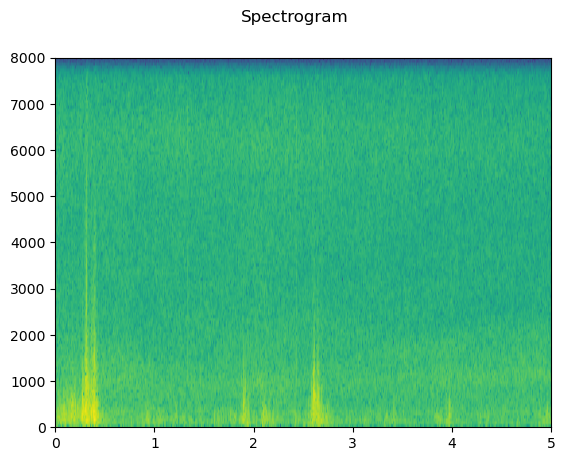

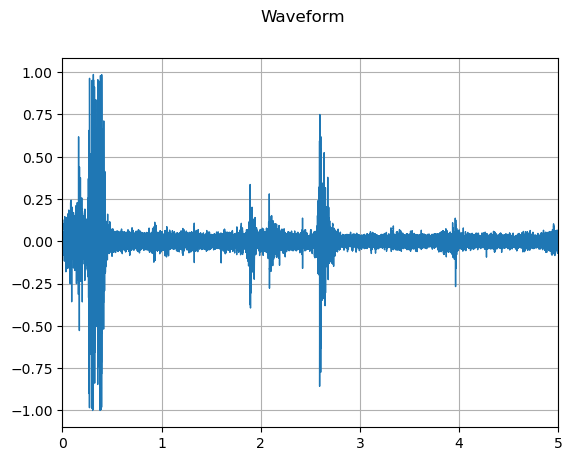

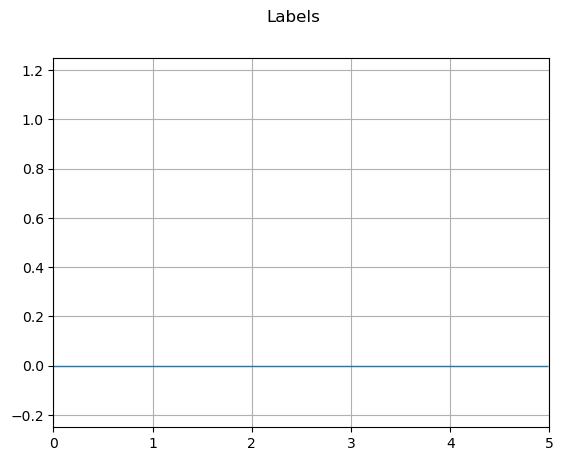

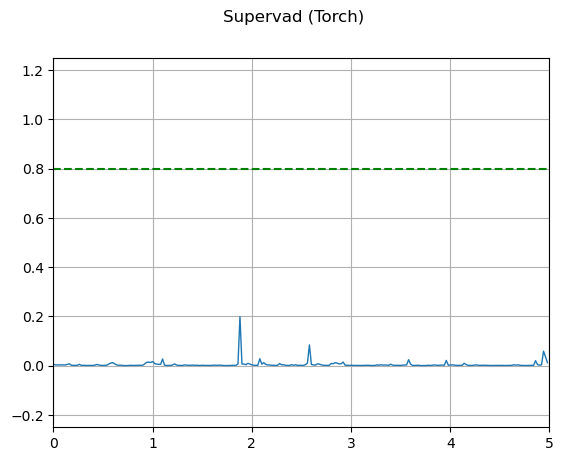

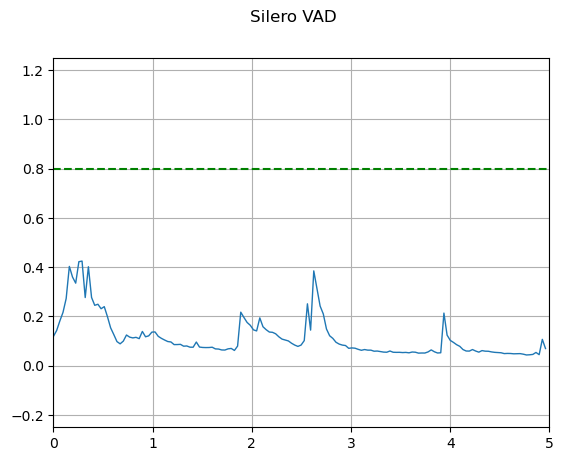

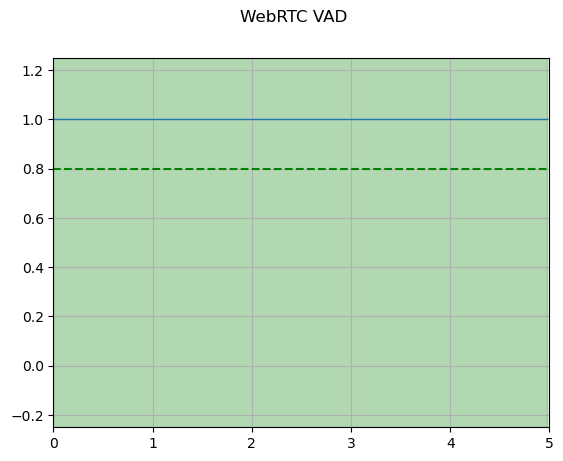

In [22]:

# If uploaded
if len(upload.value) == 1:
    with open("evaluation.wav", "w+b") as i:
        i.write(upload.value[0].content)
    sample, rate = torchaudio.load("./evaluation.wav")
    if rate != 16000:
        resampler = torchaudio.transforms.Resample(rate, 16000, dtype=waveform.dtype)
        sample = resampler(sample)
    sample = sample[0]
    duration = sample.shape[0] / 16000
    
    plot_specgram(sample.unsqueeze(0),xlim=(0,duration))
    plot_waveform(sample.unsqueeze(0),xlim=(0,duration))
    play_audio(sample)
else:
    dataset = preprocessed_audio_dataset("./datasets/supervad-1/vad_test/")
    # sample, labels = dataset[22]
    sample, labels = sample_dataset(dataset)
    duration = sample.shape[0] / 16000

    plot_specgram(sample.unsqueeze(0),xlim=(0,duration))
    plot_waveform(sample.unsqueeze(0),xlim=(0,duration))
    plot_labels(labels,xlim=(0,duration))
    play_audio(sample)

plot_labels(super_vad_torch(sample), title="Supervad (Torch)", threshold=0.8,xlim=(0,duration))
plot_labels(silero_vad(sample), sample_rate=31.25, title="Silero VAD", threshold=0.8,xlim=(0,duration))
plot_labels(webrtc_vad(sample), title="WebRTC VAD", threshold=0.8,xlim=(0,duration))

### Training evaluation

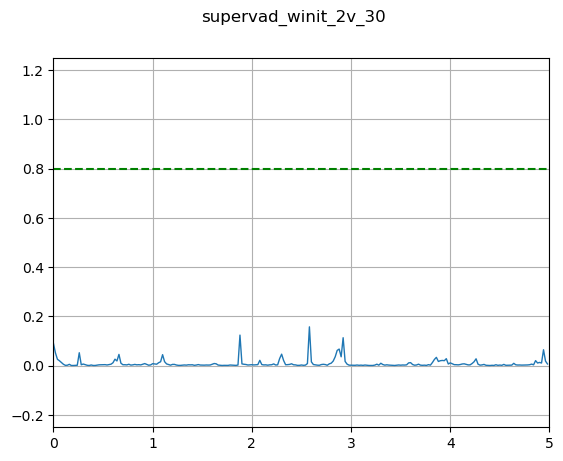

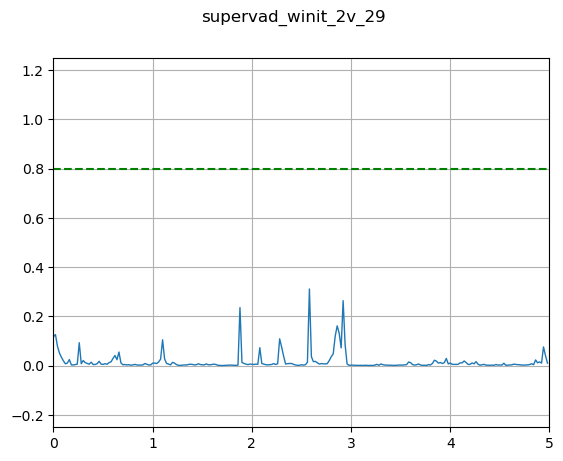

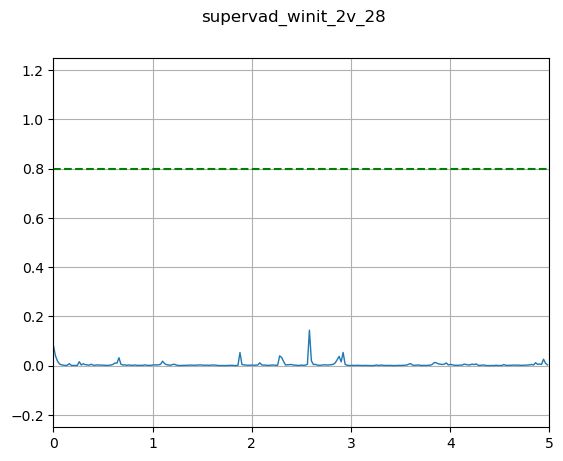

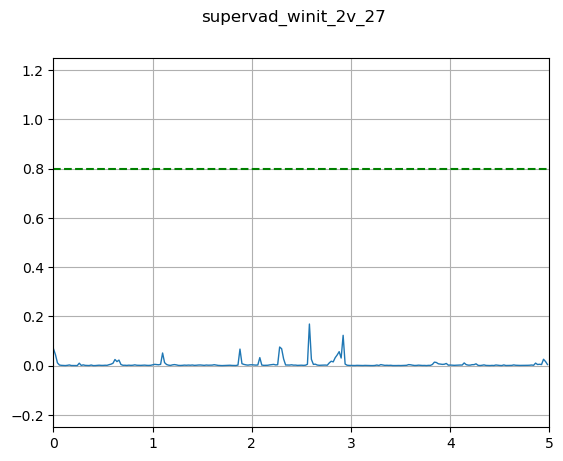

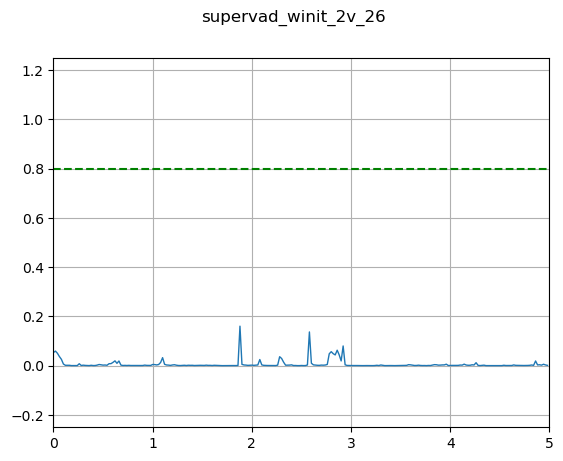

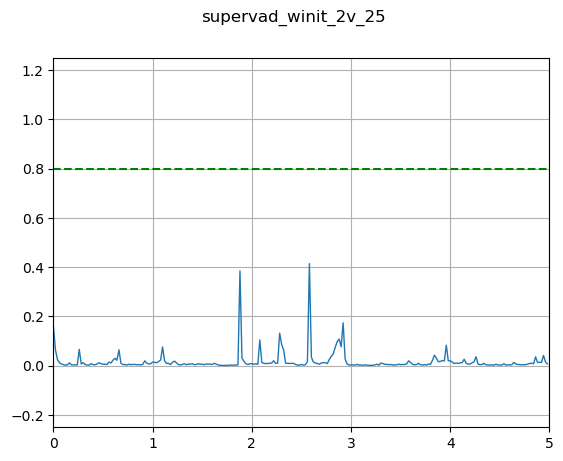

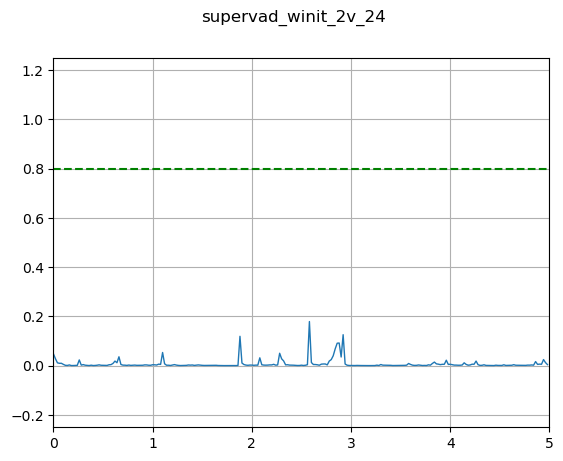

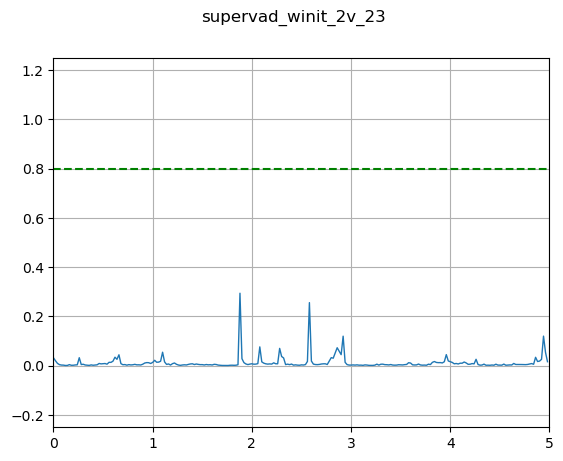

In [23]:
import pathlib

files = []
i = 1
experiment = 'supervad_winit_2v'
while True:
    if pathlib.Path(f'./checkpoints/{experiment}_{i}.pt').is_file():
        files.append(f'{experiment}_{i}')
        i = i + 1
    else:
        break

# plot_specgram(sample.unsqueeze(0))
# plot_waveform(sample.unsqueeze(0))
files.reverse()
files = files[0:8] # first 8
for f in files:
    reload_torch(supervad_pytorch = f'./checkpoints/{f}.pt', supervad_pytorch_chk = True, device="cpu")
    plot_labels(super_vad_torch(sample), title=f, threshold=0.8,xlim=(0,duration))

# Load best model
reload_torch(supervad_pytorch = f'./checkpoints/{experiment}.pt', supervad_pytorch_chk = True, device="cpu")